In [188]:
import cv2
import os
import re
import numpy as np
from skimage.filters import frangi
from skimage import img_as_float
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from imblearn.metrics import specificity_score, geometric_mean_score

In [189]:

def get_original_image(image_name):
    directory = r"database\images"
    jpg_file = os.path.join(directory, image_name)
    
    if image_name.lower().endswith('.jpg') or image_name.lower().endswith('.JPG'):
        img = Image.open(jpg_file)
        img_np = np.array(img) 
    else:
        print('Wrong image format')
        exit()

    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.title("Original image")
    plt.axis('off')
    plt.show()
    
    return img_np


In [190]:
def primary_preprocess_image(image):
    green_channel = image[:, :, 1]                              # Leave only green channel
    # kernel = np.array([[-1, -1, -1],    
    #                     [-1,  9, -1], 
    #                     [-1, -1, -1]])                          # Sharpening filter
    # sharpened_image = cv2.filter2D(green_channel, -1, kernel)   # Sharpend image

    # brightness_factor = 50
    # brightened_image = cv2.convertScaleAbs(sharpened_image, alpha=1, beta=brightness_factor)  # Increasing brightness
    
    normalized_image = cv2.equalizeHist(green_channel)       # Normalizing histogram of the image
    factor = 0.9
    darkened = np.clip(normalized_image.astype(np.float32) * factor, 0, 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(darkened, (51, 51), sigmaX=0)
    plt.figure(figsize=(6, 6))  
    plt.imshow(blurred, cmap='gray')
    plt.title("Preprocessed image")
    plt.axis('off')
    plt.show()

    return blurred


In [191]:
def main_preprocess_image(image):
    vessel_enhanced = frangi(image)
    vessel_enhanced_normalized = cv2.normalize(vessel_enhanced, None, 0, 255, cv2.NORM_MINMAX)
    image_float = img_as_float(vessel_enhanced_normalized)
    threshold_value = 30
    binary = np.where(image_float > threshold_value, 255, 0).astype(np.uint8)
    return binary

In [192]:
# PORÓWNANIE MASKI EKSPERCKIEJ Z MASKĄ WYGENEROWANĄ
def compare_masks(original_mask, generated_mask):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(generated_mask, cmap='gray')
    plt.title("Maska wygenerowana")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(original_mask, cmap='gray')
    plt.title("Maska ekspercka")
    plt.axis('off')
    plt.show()

In [193]:
def get_original_mask(original_image_name):
    mask_image_name = re.sub(r'\..*', '', original_image_name) + ".tif"
    directory = r"database\manual1"
    path_mask = os.path.join(directory, mask_image_name)
    original_mask_ready = mpimg.imread(path_mask)
    return original_mask_ready

In [194]:
def ensure_rgba(image):
    array = np.array(image)
    if array.ndim == 2:
        array = np.stack([array]*3, axis=-1)
    if array.shape[2] == 3: 
        alpha = np.full((array.shape[0], array.shape[1], 1), 255, dtype=np.uint8)
        array = np.concatenate((array, alpha), axis=2)
    return array

In [195]:
def strip_frame(mask: np.ndarray, file_name: str) -> np.ndarray:
    mask_image_name = re.sub(r'\..*', '', file_name) + "_mask.tif"
    path_mask = os.path.join(r"database\mask", mask_image_name)
    frame_mask = mpimg.imread(path_mask)

    # Konwersja RGB → grayscale, jeśli potrzeba
    if frame_mask.ndim == 3 and frame_mask.shape[2] == 3:
        frame_mask = np.mean(frame_mask, axis=2)

    # Przeskaluj wartości do 0–255, jeśli są w [0.0, 1.0]
    if frame_mask.max() <= 1.0:
        frame_mask = (frame_mask * 255)

    # Upewnij się, że mamy typ uint8
    frame_mask = frame_mask.astype(np.uint8)

    # Sprawdzenie zgodności wymiarów
    if mask.shape != frame_mask.shape:
        raise ValueError(f"Rozmiary masek się nie zgadzają: {mask.shape} vs {frame_mask.shape}")

    # Ustaw piksele na 0 tam, gdzie ramka (mask2) jest czarna
    modified_mask = mask.copy()
    modified_mask[frame_mask == 0] = 0

    return modified_mask



In [196]:
def mask_on_original_image(original_image, mask, title):
    mask_array = ensure_rgba(mask)
    original_array = ensure_rgba(original_image)

    white = [255, 255, 255]
    bright_green = [0, 255, 0, 255]

    green_mask = np.all(mask_array[:, :, :3] == white, axis=2)
    green_layer = np.zeros_like(mask_array)
    green_layer[green_mask] = bright_green
    green_image = Image.fromarray(green_layer)

    original_image = Image.fromarray(original_array).resize(green_image.size)
    combined = Image.alpha_composite(original_image, green_image)

    return combined

In [197]:
def get_algorithm_quality(original_mask, img):
    gt = (np.array(original_mask) > 0).astype(np.uint8)
    pred = np.array(img)
    if pred.ndim == 3:
        pred = pred[:, :, 0]  
    pred = (pred > 0).astype(np.uint8)
    if gt.shape != pred.shape:
        h, w = gt.shape
        pred_resized = Image.fromarray(pred * 255).resize((w, h), Image.NEAREST)
        pred = (np.array(pred_resized) > 0).astype(np.uint8)

    # Spłaszczanie do porównań
    gt_flat = gt.flatten()
    pred_flat = pred.flatten()

    # Macierz pomyłek
    tn, fp, fn, tp = confusion_matrix(gt_flat, pred_flat, labels=[0, 1]).ravel()

    # Miary jakości
    acc = accuracy_score(gt_flat, pred_flat)
    sensitivity = recall_score(gt_flat, pred_flat, pos_label=1)
    specificity = specificity_score(gt_flat, pred_flat, pos_label=1)
    geometric_mean = geometric_mean_score(gt_flat, pred_flat, average='binary')

    return {
        "True Positive": tp,
        "True Negative": tn,
        "False Positive": fp,
        "False Negative": fn,
        "Accuracy": acc,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Geometric Mean": geometric_mean
    }


In [ ]:
def first_step():
    for i in range(1,6):
        image= f"{i:02}_dr.JPG"
        img = get_original_image(image)
        first_mask = primary_preprocess_image(img)                  #Wstępne przetworzenie obrazu

        generated_mask = main_preprocess_image(first_mask)           #Właściwe przetworzenie obrazu
        original_mask = get_original_mask(image)               

        generated_mask = strip_frame(generated_mask, image)         #Usunięcie ramki

        compare_masks(original_mask, generated_mask)                 #Porównanie maski eksperckiej

        title_mask = 'Maska na oryginalnym zdjęcia'
        mask_on_image = mask_on_original_image(img, generated_mask, title_mask)                      #Maska na oryginalnym zdjęciu
        title_original_mask = 'Maska ekspercka na oryginalnym zdjęciu'
        original_mask_on_image = mask_on_original_image(img, original_mask, title_original_mask)     #Maska ekspercka na oryginalnym zdjęciu
        compare_masks(original_mask_on_image, mask_on_image) 

        results = get_algorithm_quality(original_mask, generated_mask)
        print("Confusion matrix:")
        for k, v in results.items():
            print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

In [ ]:
def second_step(image_name):
    directory_image = r"database\images"
    directory_mask = r"database\mask"
    mask_name = re.sub(r'\..*', '', image_name) + "_mask.tif"
    image = os.path.join(directory_image, image_name)
    mask = os.path.join(directory_mask, mask_name)
    
    if image_name.lower().endswith('.jpg') or image_name.lower().endswith('.JPG'):
        image = Image.open(image).convert("RGB")
        image_np = np.array(image) 
    image_np = primary_preprocess_image(image_np)  

    if mask_name.lower().endswith('.jpg') or mask_name.lower().endswith('.JPG'):
        mask = Image.open(mask).convert("RGB")
        mask_np = np.array(mask)

    block_size = 5
    height, width, _ = image_np.shape

    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            image_block = image_np[y:y+block_size, x:x+block_size]
            mask_block = mask_np[y:y+block_size, x:x+block_size]

        # Sprawdź, czy maska zawiera czarne piksele
        if not np.any(np.all(mask_block == [0, 0, 0], axis=-1)):
            
   


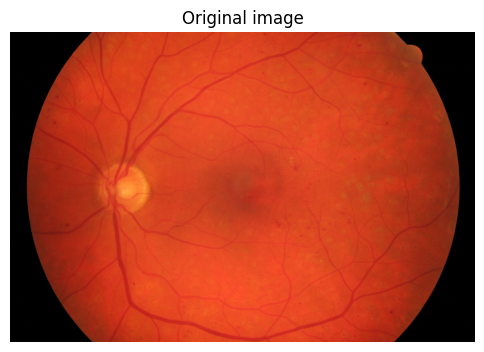

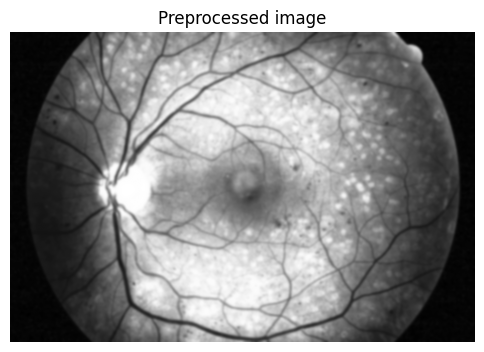

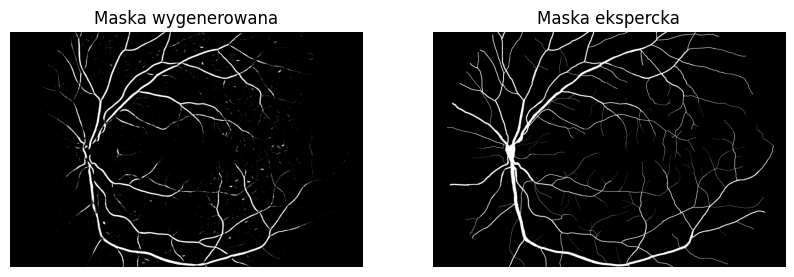

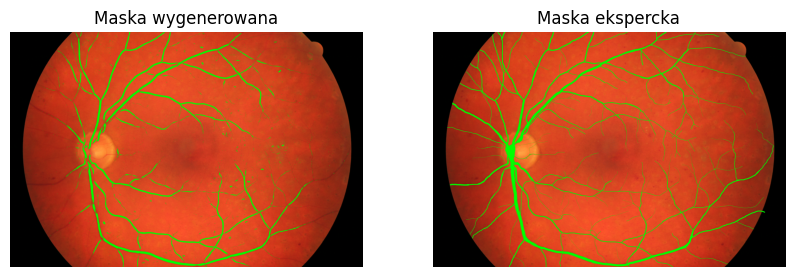

Confusion matrix:
True Positive: 224871
True Negative: 7655006
False Positive: 114056
False Negative: 191411
Accuracy: 0.9627
Sensitivity: 0.5402
Specificity: 0.9853
Geometric Mean: 0.7296


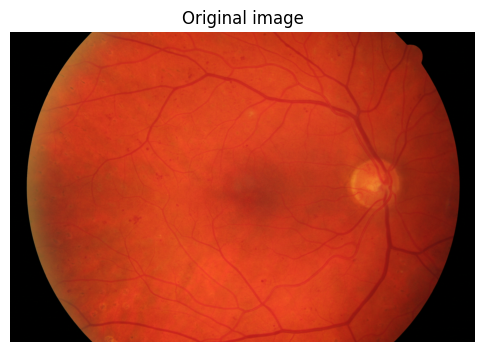

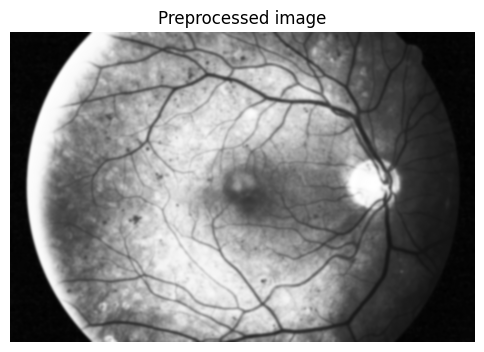

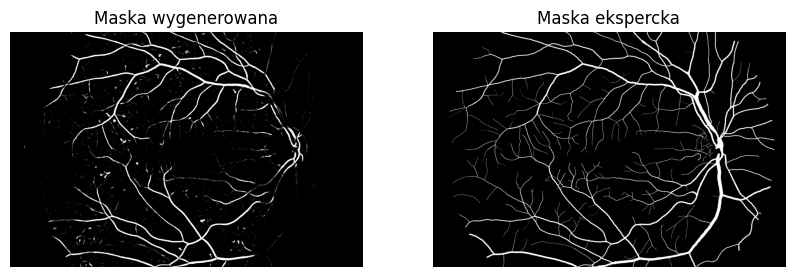

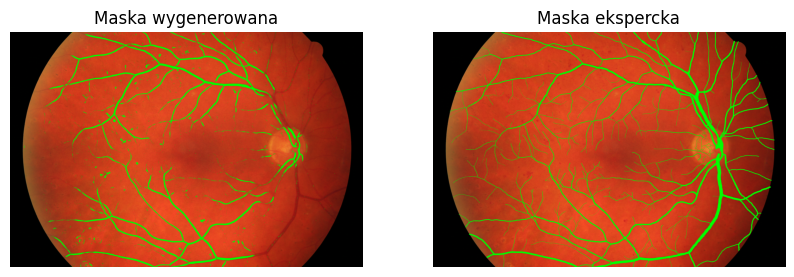

Confusion matrix:
True Positive: 246278
True Negative: 7523762
False Positive: 139704
False Negative: 275600
Accuracy: 0.9493
Sensitivity: 0.4719
Specificity: 0.9818
Geometric Mean: 0.6807


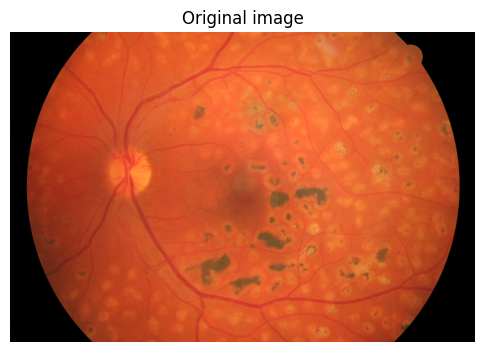

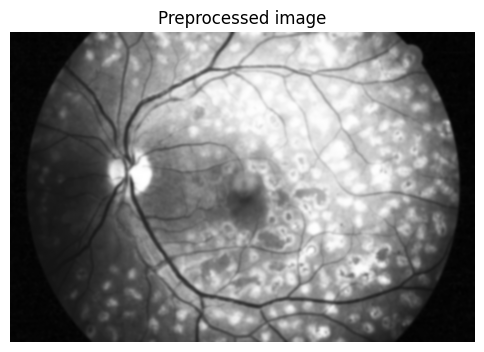

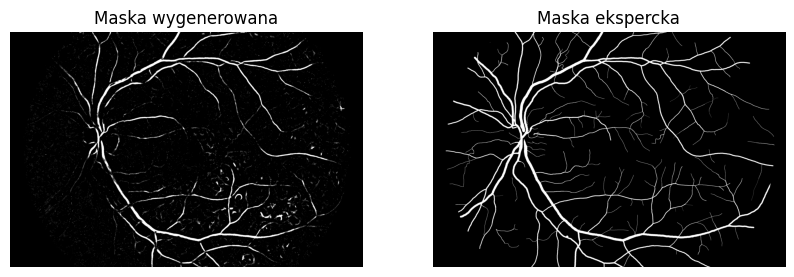

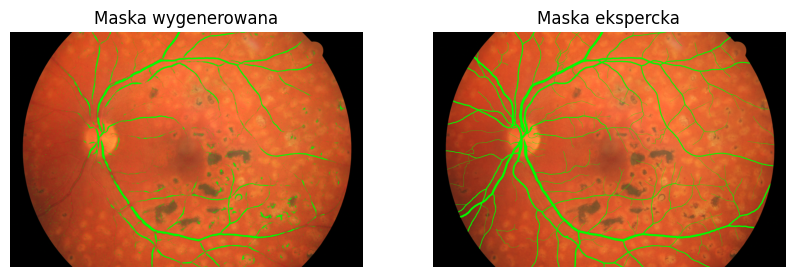

Confusion matrix:
True Positive: 220309
True Negative: 7567732
False Positive: 123212
False Negative: 274091
Accuracy: 0.9515
Sensitivity: 0.4456
Specificity: 0.9840
Geometric Mean: 0.6622


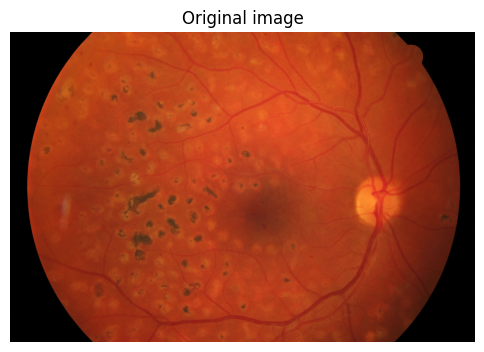

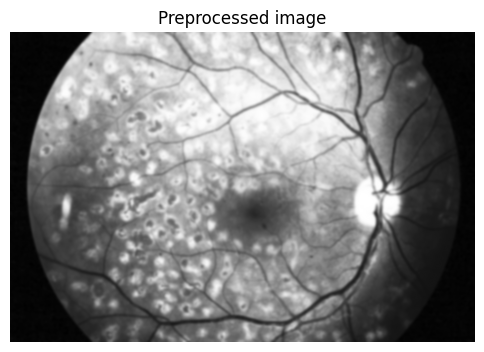

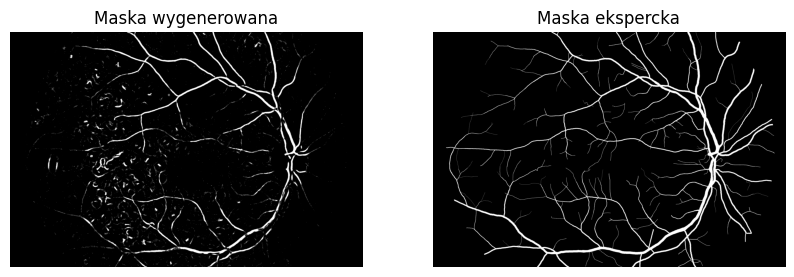

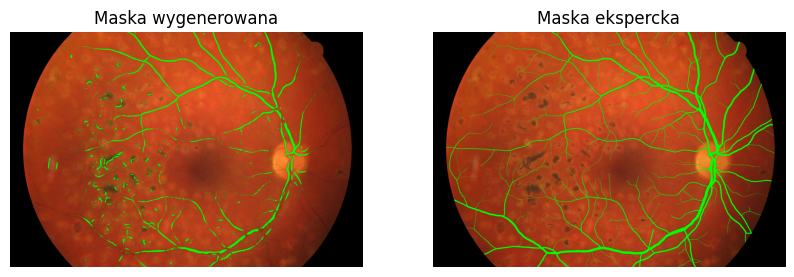

Confusion matrix:
True Positive: 201411
True Negative: 7598342
False Positive: 124823
False Negative: 260768
Accuracy: 0.9529
Sensitivity: 0.4358
Specificity: 0.9838
Geometric Mean: 0.6548


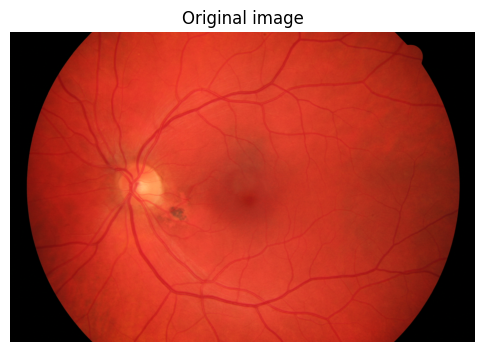

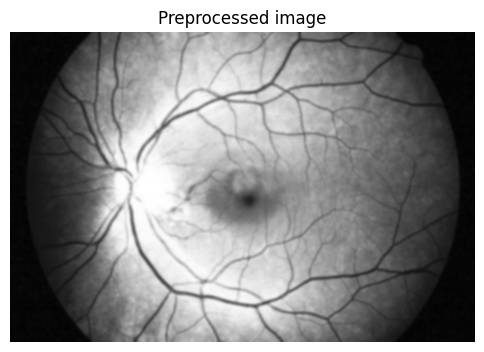

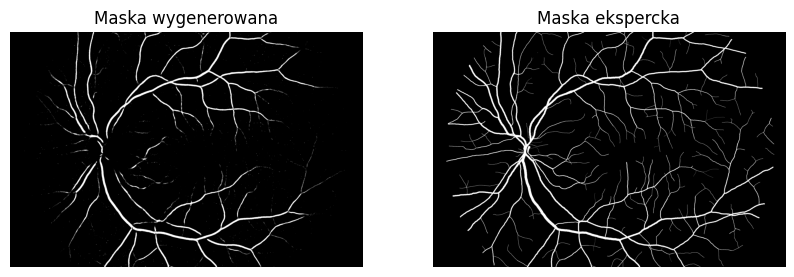

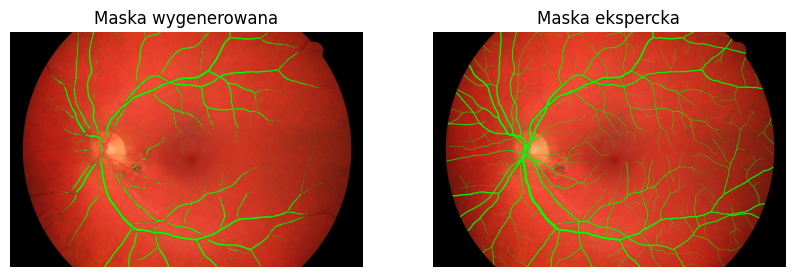

Confusion matrix:
True Positive: 261810
True Negative: 7607744
False Positive: 68622
False Negative: 247168
Accuracy: 0.9614
Sensitivity: 0.5144
Specificity: 0.9911
Geometric Mean: 0.7140


In [ ]:
image_name = r"01_dr.JPG"
img = get_original_image(image_name)
first_mask = primary_preprocess_image(img)                  #Wstępne przetworzenie obrazu

